In [25]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnchoredText
import scipy.optimize
import pandas as pd
from IPython.display import clear_output
from time import sleep



In [26]:
#read in the data from csv file
data = []
with open('exercise7_sim_animation.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    next(contents)#skip header line
    for row in contents:
        array= np.asarray(row).astype('int')
        data.append(np.reshape(array,(50,50)))


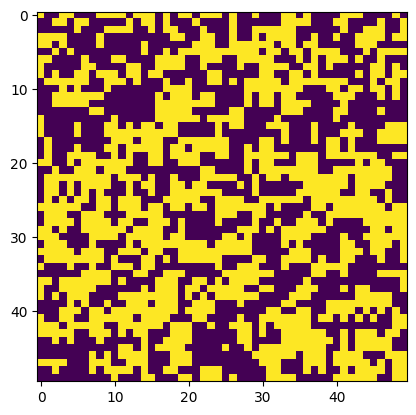

In [28]:

for i in range(len(data)):

    plt.imshow(data[i])
    plt.show()

    sleep(0.001)
    clear_output(wait=True)

In [ ]:

for i in range(10000):

    plt.imshow(data[i])
    plt.show()

    sleep(0.1)
    clear_output(wait)

In [ ]:

for i in range(10000):

    plt.imshow(data[i])
    plt.show()

    sleep(0.1)
    clear_output(wait)